# Clustering des Comportements Étudiants dans les QCM en Ligne

### Importation des bibliothèques

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import seaborn as sns
import warnings
import re

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")

## Fusion des datasets & Ajout de colonne Filière

In [43]:
# Liste des fichiers dans l'ordre souhaité
files = [
    ("/kaggle/input/pfe-dataset/MTU BCG-notes.xlsx", "BCG"),
    ("/kaggle/input/pfe-dataset/MTU IA-notes.xlsx", "IA"),
    ("/kaggle/input/pfe-dataset/MTU MIP-notes.xlsx", "MTU"),
    ("/kaggle/input/pfe-dataset/MTU PC-notes.xlsx", "PC")
]

# Lire et fusionner
df_list = []
for file_path, filiere in files:
    df = pd.read_excel(file_path)
    df = df.iloc[:-1] # Suppression de la dernière ligne (moyenne globale) avant fusion
    df["Filière"] = filiere
    df_list.append(df)

# Fusionner tous les fichiers
df = pd.concat(df_list, ignore_index=True)

# Sauvegarde
df.to_excel("/kaggle/working/donnees_fusionnees.xlsx", index=False)

## Prétraitement et Nettoyage des données 

### Affichage de nombre des valeures nulls et doublons

In [45]:
print(df.isna().sum().sum())
print(df.duplicated().sum())

0
0


### Gestion des notes (questions + note finale)

In [46]:
# Colonnes des questions (Q. 1 à Q. 20) et note finale
question_cols = [f'Q. {i} /1,00' for i in range(1, 21)] + ['Note/20,00']

# Remplace "-" par NaN et convertit en float
for col in question_cols:
    df[col] = df[col].replace("-", np.nan).str.replace(',', '.').astype(float)

# Supprime les lignes où la note finale est NaN
df = df.dropna(subset=['Note/20,00'])

# Remplit les NaN des questions par 0
df[question_cols[:-1]] = df[question_cols[:-1]].fillna(0)

### Conversion du temps utilisé

In [47]:
def convert_time(time_str):
    if pd.isna(time_str) or time_str == "-":
        return np.nan
    
    # Cas 1: Format "X heures Y min"
    if 'heures' in time_str:
        parts = time_str.split('heures')
        heures = float(parts[0].strip())
        reste = parts[1].strip()
        
        if 'min' in reste:
            mins = float(reste.split('min')[0].strip())
        else:
            mins = 0
        return heures * 60 + mins
    
    # Cas 2: Format "X min Y s" 
    elif 'min' in time_str:
        parts = time_str.split('min')
        mins = float(parts[0].strip())
        secs = float(parts[1].replace('s', '').strip()) if 's' in parts[1] else 0
        return mins + secs / 60
    
    # Cas 3: Format "X s" 
    elif 's' in time_str:
        return float(time_str.replace('s', '').strip()) / 60
    
    # Si aucun format reconnu
    else:
        return np.nan

df['Temps utilisé (min)'] = df['Temps utilisé'].apply(convert_time)
df = df.drop('Temps utilisé', axis=1)

### Suppression des valeurs aberrantes

In [48]:
# On limite le temps utilisé au temps autorisé
df = df[df['Temps utilisé (min)'] < 35]

### Concaténation de Prénom et Nom

In [49]:
df['Nom Complet'] = df['Prénom'] + ' ' + df['Nom']

### Réorganiser les colonnes

In [50]:
df.columns

Index(['Nom', 'Prénom', 'Adresse de courriel', 'État', 'Commencé le',
       'Terminé', 'Note/20,00', 'Q. 1 /1,00', 'Q. 2 /1,00', 'Q. 3 /1,00',
       'Q. 4 /1,00', 'Q. 5 /1,00', 'Q. 6 /1,00', 'Q. 7 /1,00', 'Q. 8 /1,00',
       'Q. 9 /1,00', 'Q. 10 /1,00', 'Q. 11 /1,00', 'Q. 12 /1,00',
       'Q. 13 /1,00', 'Q. 14 /1,00', 'Q. 15 /1,00', 'Q. 16 /1,00',
       'Q. 17 /1,00', 'Q. 18 /1,00', 'Q. 19 /1,00', 'Q. 20 /1,00', 'Filière',
       'Temps utilisé (min)', 'Nom Complet'],
      dtype='object')

In [51]:
df = df[['Nom Complet', 'Filière','Temps utilisé (min)', 'Note/20,00', 'Q. 1 /1,00', 'Q. 2 /1,00', 'Q. 3 /1,00',
       'Q. 4 /1,00', 'Q. 5 /1,00', 'Q. 6 /1,00', 'Q. 7 /1,00', 'Q. 8 /1,00',
       'Q. 9 /1,00', 'Q. 10 /1,00', 'Q. 11 /1,00', 'Q. 12 /1,00',
       'Q. 13 /1,00', 'Q. 14 /1,00', 'Q. 15 /1,00', 'Q. 16 /1,00',
       'Q. 17 /1,00', 'Q. 18 /1,00', 'Q. 19 /1,00', 'Q. 20 /1,00']]

### Affichage des types de colonnes après le nettoyage

In [52]:
print(df.dtypes)

Nom Complet             object
Filière                 object
Temps utilisé (min)    float64
Note/20,00             float64
Q. 1 /1,00             float64
Q. 2 /1,00             float64
Q. 3 /1,00             float64
Q. 4 /1,00             float64
Q. 5 /1,00             float64
Q. 6 /1,00             float64
Q. 7 /1,00             float64
Q. 8 /1,00             float64
Q. 9 /1,00             float64
Q. 10 /1,00            float64
Q. 11 /1,00            float64
Q. 12 /1,00            float64
Q. 13 /1,00            float64
Q. 14 /1,00            float64
Q. 15 /1,00            float64
Q. 16 /1,00            float64
Q. 17 /1,00            float64
Q. 18 /1,00            float64
Q. 19 /1,00            float64
Q. 20 /1,00            float64
dtype: object


## Analyse exploratoire (EDA)

### Distribution des Notes

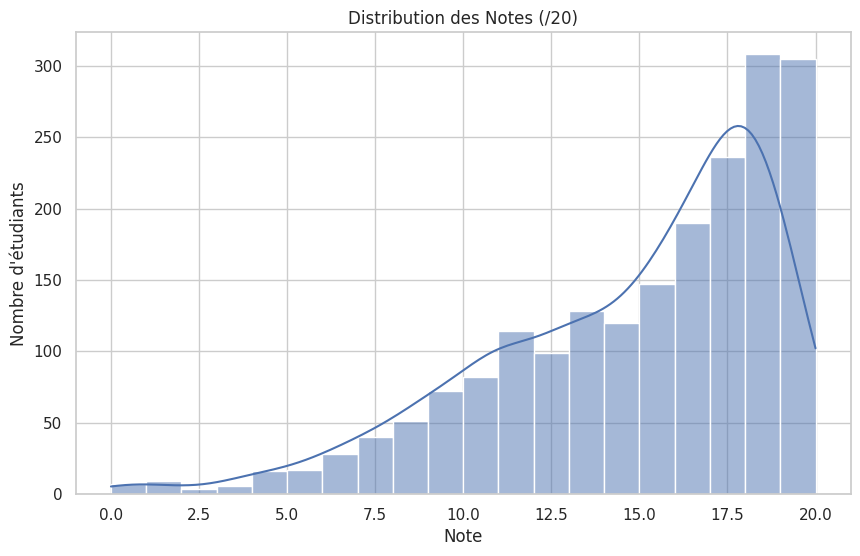

In [55]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Note/20,00'], bins=20, kde=True)
plt.title("Distribution des Notes (/20)")
plt.xlabel("Note")
plt.ylabel("Nombre d'étudiants")
plt.show()

### Analyse par Filière

### Performance des Filières : Notes vs Temps

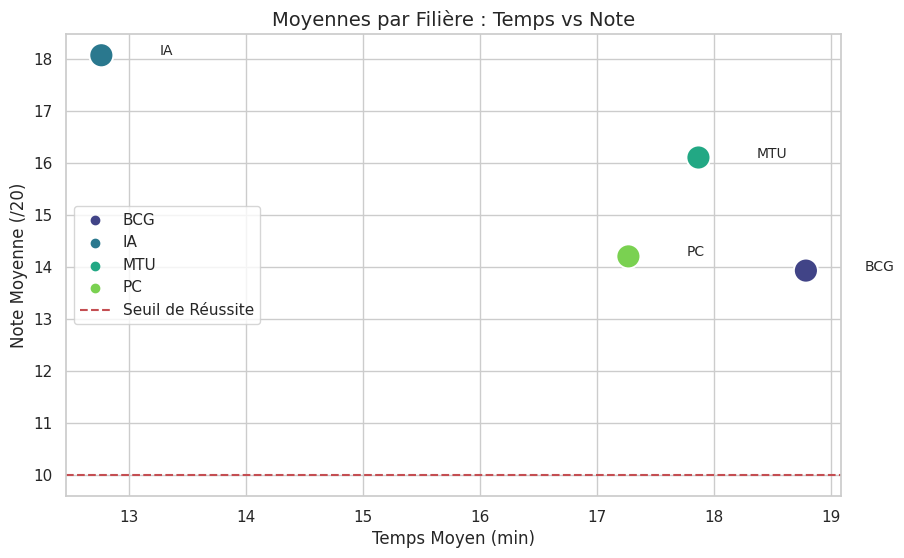

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calcul des moyennes par filière
moyennes = df.groupby("Filière")[["Temps utilisé (min)", "Note/20,00"]].mean().reset_index()

# Tracer le nuage de points des moyennes par filière
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=moyennes,
    x="Temps utilisé (min)",
    y="Note/20,00",
    hue="Filière",
    s=300,
    palette="viridis"
)

# Ajouter des étiquettes aux points
for i in range(len(moyennes)):
    plt.text(
        x=moyennes["Temps utilisé (min)"][i] + 0.5,
        y=moyennes["Note/20,00"][i],
        s=moyennes["Filière"][i],
        fontsize=10
    )

# Titres et axes
plt.title("Moyennes par Filière : Temps vs Note", fontsize=14)
plt.xlabel("Temps Moyen (min)", fontsize=12)
plt.ylabel("Note Moyenne (/20)", fontsize=12)

# Seuil de réussite
plt.axhline(y=10, color='r', linestyle='--', label="Seuil de Réussite")

plt.grid(True)
plt.legend()
plt.show()

### Performance des Filières : Notes vs Filières

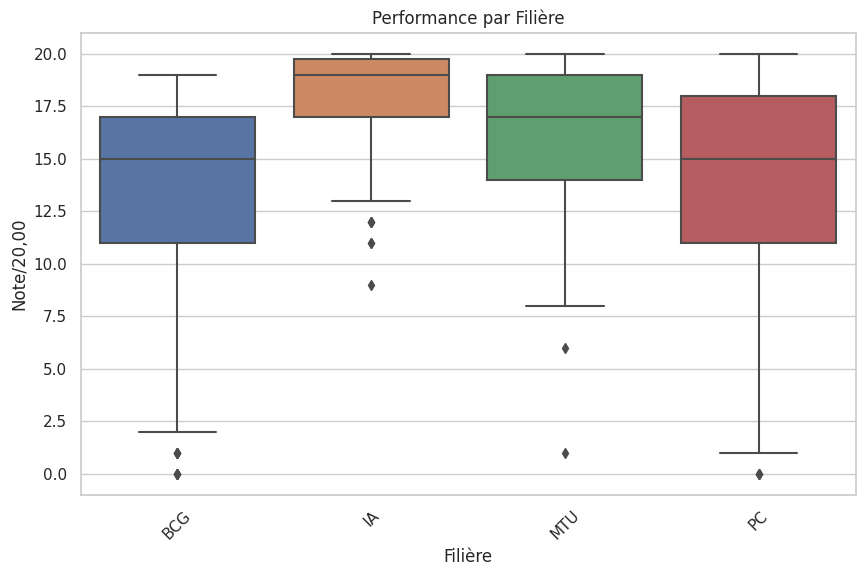

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Filière', y='Note/20,00', data=df)
plt.title("Performance par Filière")
plt.xticks(rotation=45)
plt.show()

### Analyse des Questions (Q. 1 à Q. 20)

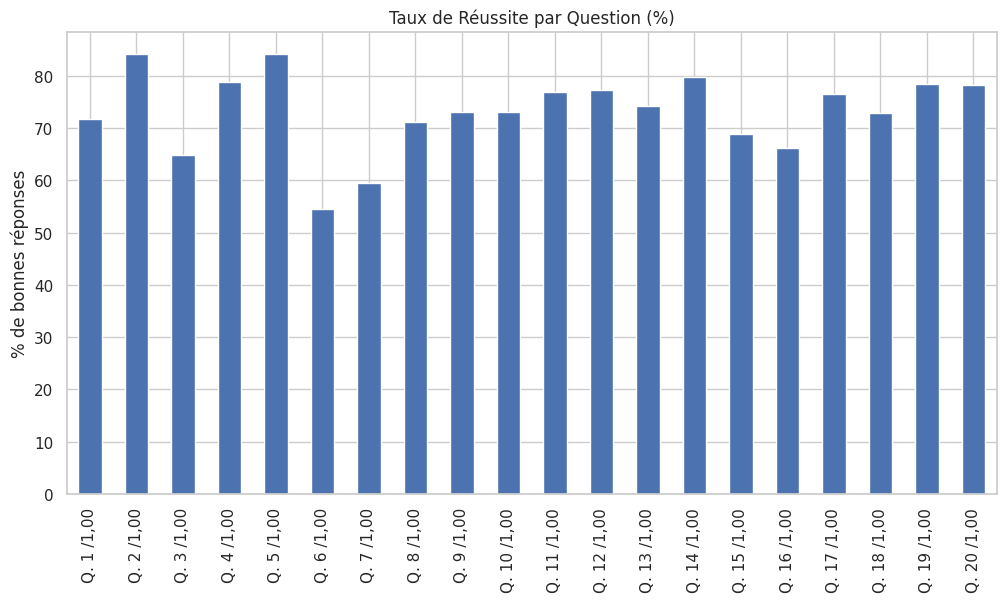

In [58]:
success_rate = df[[f'Q. {i} /1,00' for i in range(1, 21)]].mean() * 100
success_rate.plot(kind='bar', figsize=(12, 6))
plt.title("Taux de Réussite par Question (%)")
plt.ylabel("% de bonnes réponses")
plt.show()

### Matrice de Corrélation des Questions

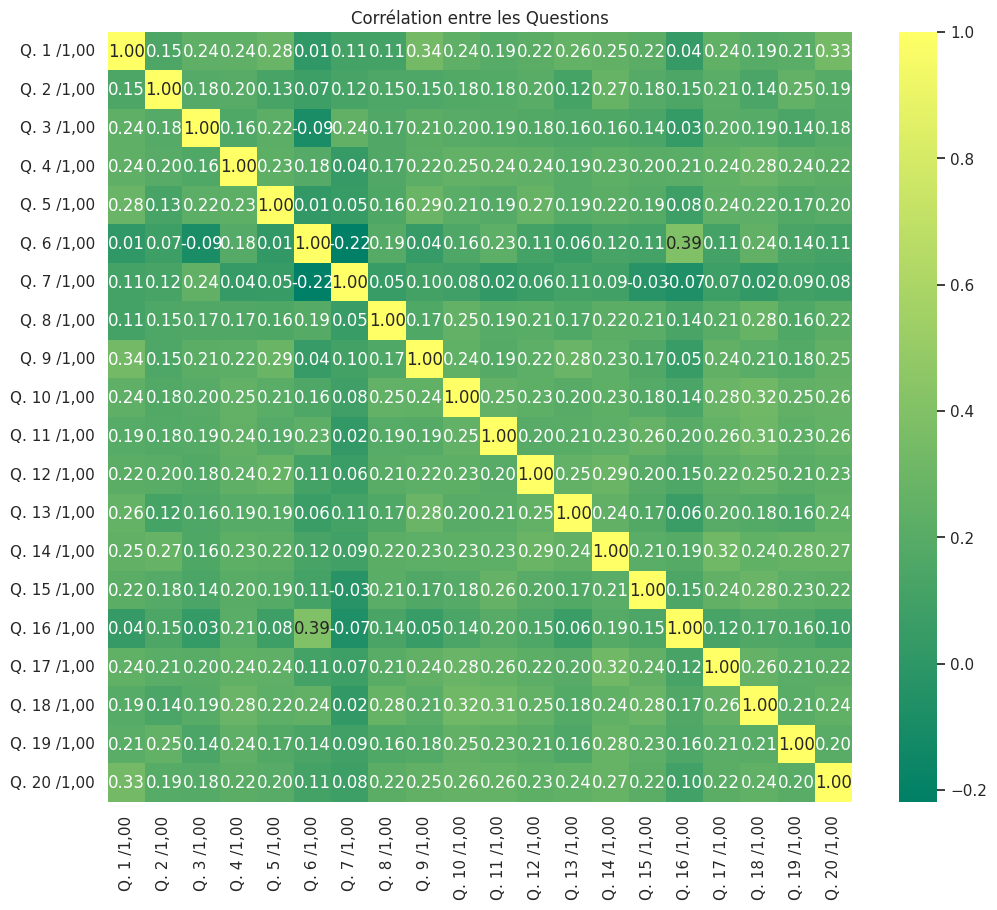

In [59]:
corr_matrix = df[[f'Q. {i} /1,00' for i in range(1, 21)]].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='summer', fmt=".2f")
plt.title("Corrélation entre les Questions")
plt.show()

### Profil des Filières

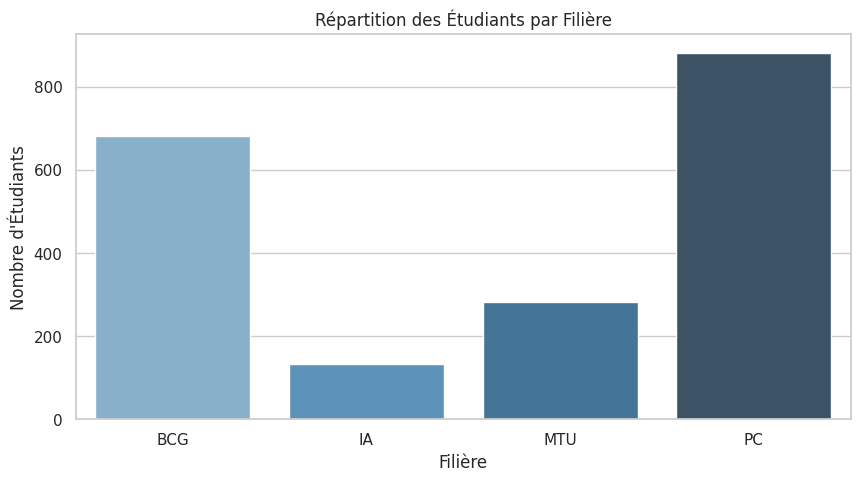

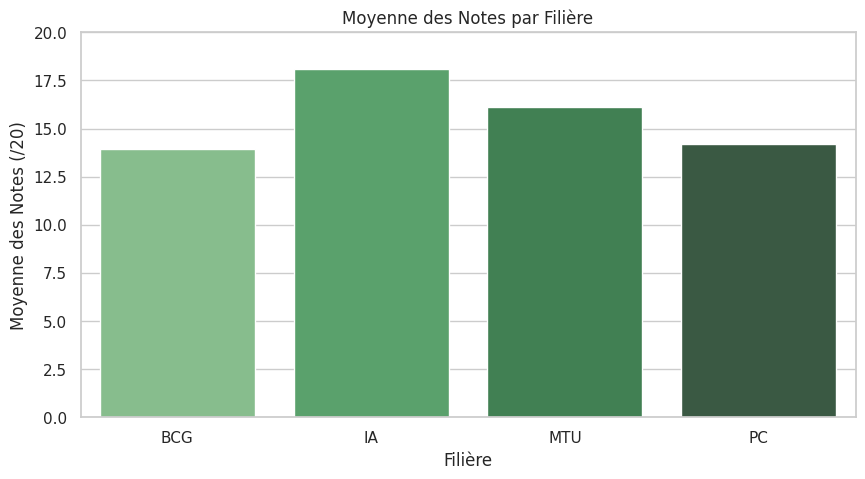

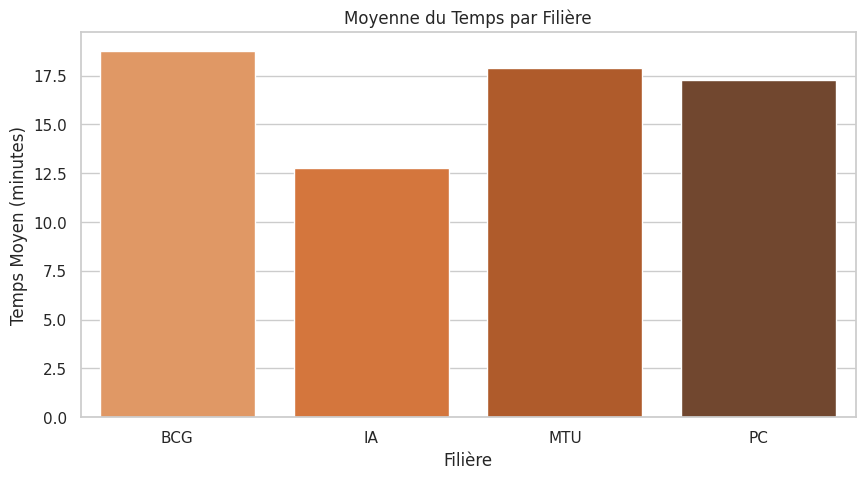

In [60]:
# Calcul des statistiques par filière
df_grouped = df.groupby("Filière").agg({
    "Note/20,00": "mean",
    "Temps utilisé (min)": "mean",
    "Filière": "count"  # Compter le nombre d'étudiants
}).rename(columns={
    "Note/20,00": "Moyenne Notes",
    "Temps utilisé (min)": "Moyenne Temps",
    "Filière": "Total Étudiants"
}).reset_index()

# Set style
sns.set_theme(style="whitegrid")

# Plot 1: Distribution des etudiants par filière
plt.figure(figsize=(10, 5))
sns.barplot(x="Filière", y="Total Étudiants", data=df_grouped, palette="Blues_d")
plt.title("Répartition des Étudiants par Filière")
plt.xlabel("Filière")
plt.ylabel("Nombre d'Étudiants")
plt.show()

# Plot 2: Moyenne des notes par filière
plt.figure(figsize=(10, 5))
sns.barplot(x="Filière", y="Moyenne Notes", data=df_grouped, palette="Greens_d")
plt.title("Moyenne des Notes par Filière")
plt.xlabel("Filière")
plt.ylabel("Moyenne des Notes (/20)")
plt.ylim(0, 20)
plt.show()

# Plot 3: Moyenne des notes par filière
plt.figure(figsize=(10, 5))
sns.barplot(x="Filière", y="Moyenne Temps", data=df_grouped, palette="Oranges_d")
plt.title("Moyenne du Temps par Filière")
plt.xlabel("Filière")
plt.ylabel("Temps Moyen (minutes)")
plt.show()

### Analyse des Valeurs Manquantes

In [61]:
print("Valeurs manquantes par colonne :")
print(df.isnull().sum())

Valeurs manquantes par colonne :
Nom Complet            0
Filière                0
Temps utilisé (min)    0
Note/20,00             0
Q. 1 /1,00             0
Q. 2 /1,00             0
Q. 3 /1,00             0
Q. 4 /1,00             0
Q. 5 /1,00             0
Q. 6 /1,00             0
Q. 7 /1,00             0
Q. 8 /1,00             0
Q. 9 /1,00             0
Q. 10 /1,00            0
Q. 11 /1,00            0
Q. 12 /1,00            0
Q. 13 /1,00            0
Q. 14 /1,00            0
Q. 15 /1,00            0
Q. 16 /1,00            0
Q. 17 /1,00            0
Q. 18 /1,00            0
Q. 19 /1,00            0
Q. 20 /1,00            0
dtype: int64


## Choix et évaluation de modèles

### Normalisation des colonnes catégorielles

In [63]:
X = df[["Temps utilisé (min)", "Note/20,00"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Modèle KMeans

In [64]:
kmeans = KMeans(n_clusters=5, random_state=42)
df["KMeans_cluster"] = kmeans.fit_predict(X_scaled)

### Modèle DBSCAN

In [65]:
dbscan = DBSCAN(eps=0.8, min_samples=2)
df["DBSCAN_cluster"] = dbscan.fit_predict(X_scaled)

### Modèle Agglomerative

In [66]:
agglo = AgglomerativeClustering(n_clusters=5)
df["Agglomerative_cluster"] = agglo.fit_predict(X_scaled)

### Visualisation des modèles

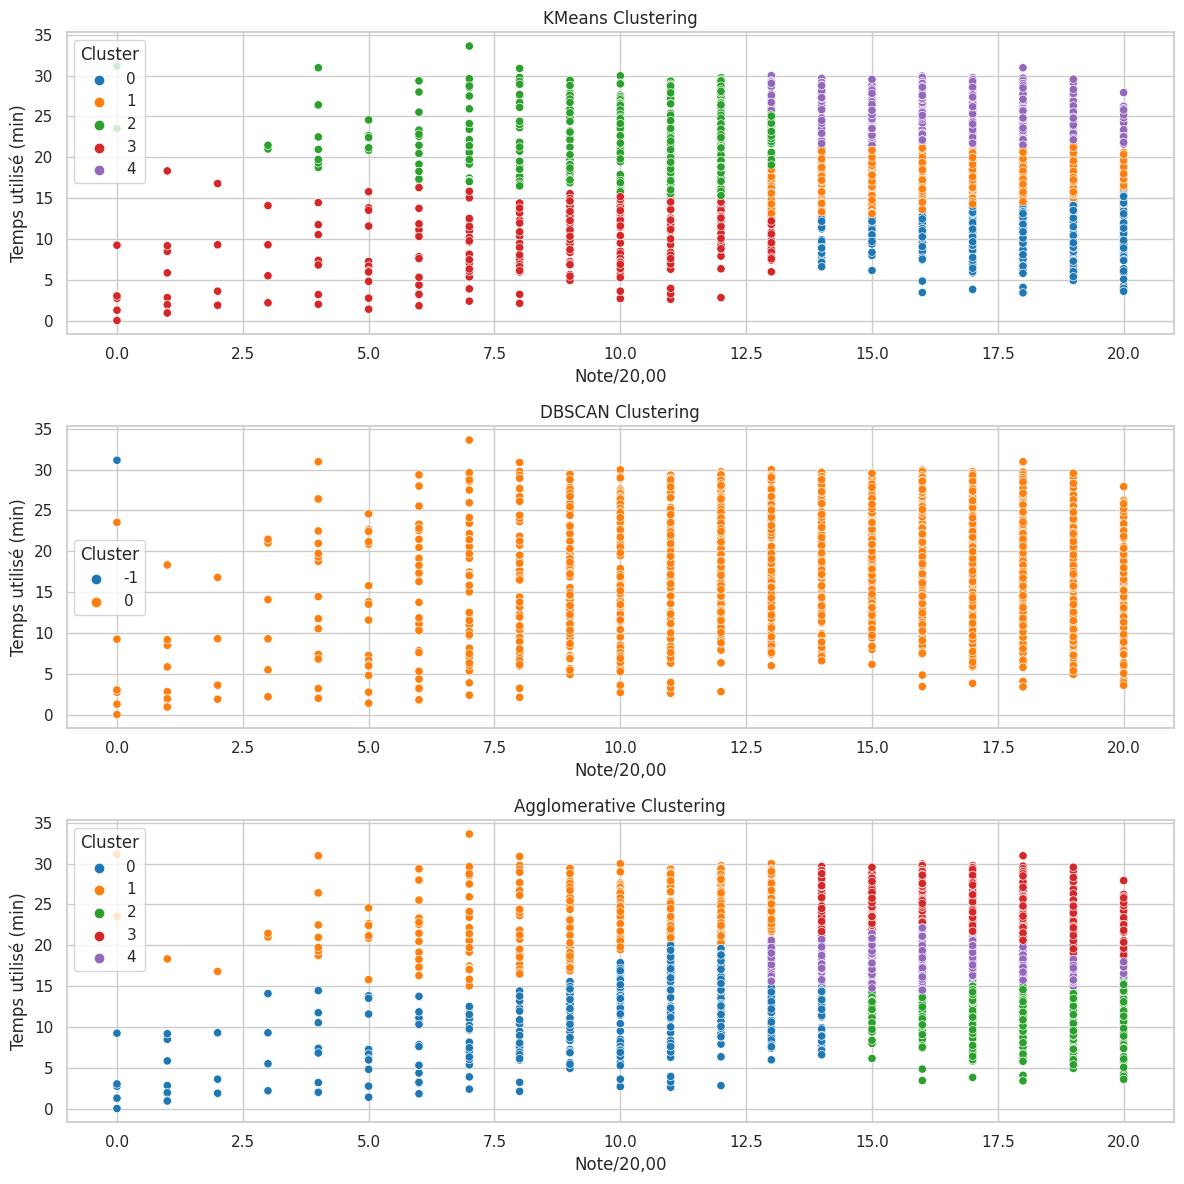

In [67]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  

# KMeans
sns.scatterplot(x="Note/20,00", y="Temps utilisé (min)", 
                hue="KMeans_cluster", data=df, ax=axes[0], palette="tab10")
axes[0].set_title("KMeans Clustering")
axes[0].legend(title="Cluster")

# DBSCAN
sns.scatterplot(x="Note/20,00", y="Temps utilisé (min)", 
                hue="DBSCAN_cluster", data=df, ax=axes[1], palette="tab10")
axes[1].set_title("DBSCAN Clustering")
axes[1].legend(title="Cluster")

# Agglomerative
sns.scatterplot(x="Note/20,00", y="Temps utilisé (min)", 
                hue="Agglomerative_cluster", data=df, ax=axes[2], palette="tab10")
axes[2].set_title("Agglomerative Clustering")
axes[2].legend(title="Cluster")

plt.tight_layout()
plt.show()

### Trouver K optimal pour KMeans

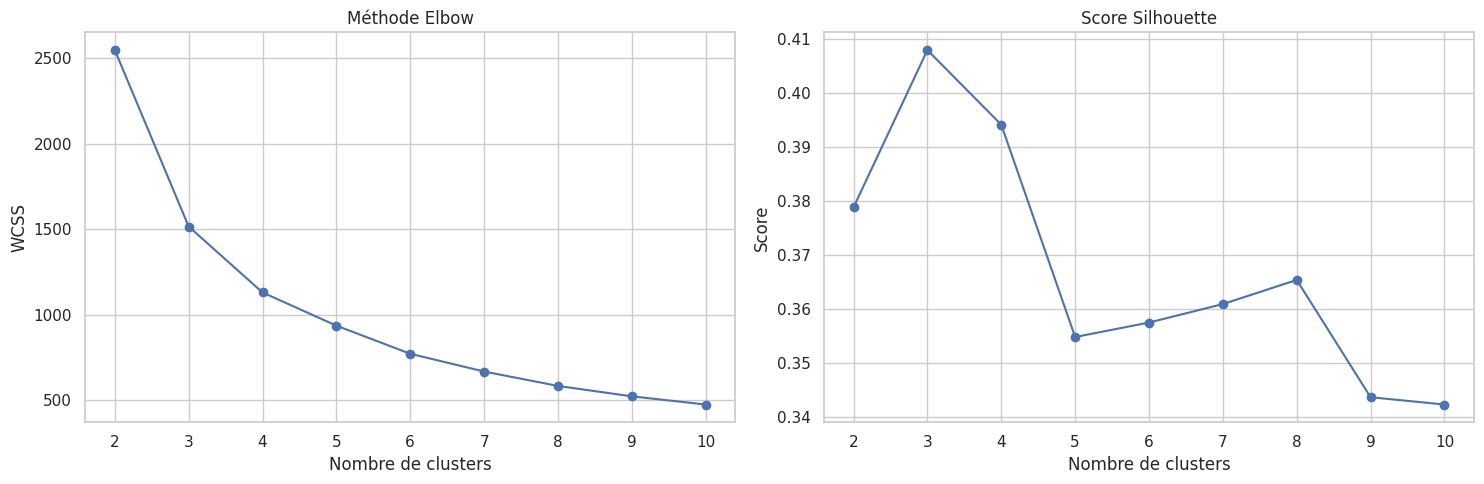

In [68]:
def find_optimal_clusters(data, max_k=10):
    wcss = []
    silhouette_scores = []
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        
        if k > 1:  # Le score silhouette n'est pas défini pour k=1
            silhouette_scores.append(silhouette_score(data, kmeans.labels_))
    
    # Plot WCSS
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_k+1), wcss, marker='o')
    plt.title('Méthode Elbow')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('WCSS')
    
    # Plot Silhouette Score
    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_k+1), silhouette_scores, marker='o')
    plt.title('Score Silhouette')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    return wcss, silhouette_scores

wcss, silhouette_scores = find_optimal_clusters(X_scaled)

### Utiliser K optimal pour l'entrainement
La courbe chute fortement après K=4

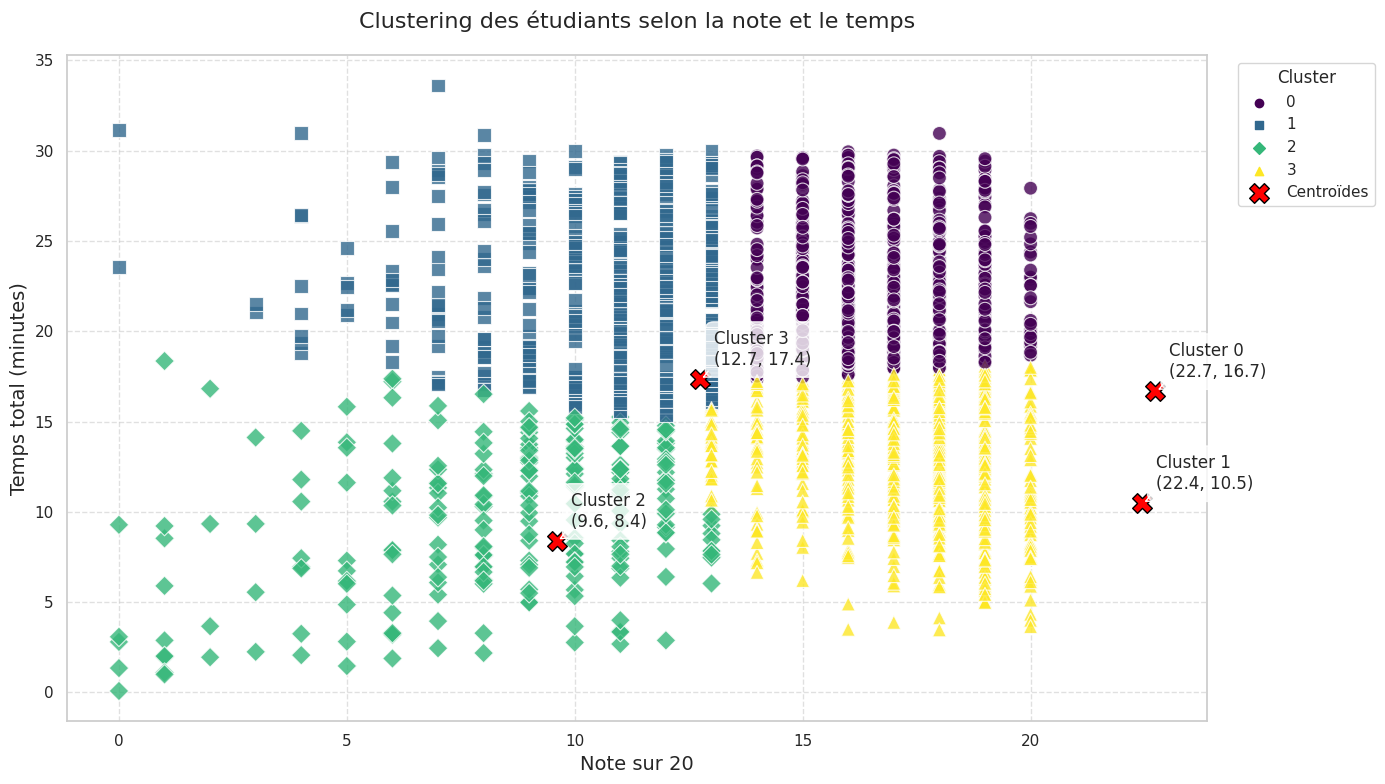

In [69]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_scaled)

# --- Visualisation des clusters ---
plt.figure(figsize=(14, 8))

# Scatter plot
scatter = sns.scatterplot(
    x="Note/20,00",
    y="Temps utilisé (min)",
    hue="cluster",
    data=df,
    palette="viridis",
    s=100,
    alpha=0.8,
    style="cluster",
    markers=["o", "s", "D", "^"][:optimal_k]
)

# Centroïdes
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='X',
    s=200,
    c='red',
    label='Centroïdes',
    edgecolor='black'
)

# Personnalisation
plt.title("Clustering des étudiants selon la note et le temps", fontsize=16, pad=20)
plt.xlabel("Note sur 20", fontsize=14)
plt.ylabel("Temps total (minutes)", fontsize=14)
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)

# Ajouter les annotations des centroïdes
for i, (note, temps) in enumerate(centroids):
    plt.annotate(
        f'Cluster {i}\n({note:.1f}, {temps:.1f})',
        xy=(note, temps),
        xytext=(10, 10),
        textcoords='offset points',
        bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8),
        arrowprops=dict(arrowstyle='->')
    )

plt.tight_layout()
plt.show()

### Analyse statistique de clusters

In [70]:
print("Statistiques par cluster:")
cluster_stats = df.groupby('cluster')[['Note/20,00', 'Temps utilisé (min)']].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max'])
print(cluster_stats)

Statistiques par cluster:
        Note/20,00                                          \
             count       mean median       std   min   max   
cluster                                                      
0              643  16.696734   17.0  1.698388  14.0  20.0   
1              402  10.490050   11.0  2.394122   0.0  13.0   
2              244   8.385246    9.0  3.176422   0.0  13.0   
3              690  17.356522   18.0  1.804806  13.0  20.0   

        Temps utilisé (min)                                             \
                      count       mean     median       std        min   
cluster                                                                  
0                       643  22.737429  22.366667  3.381438  17.350000   
1                       402  22.441791  22.300000  4.132148  15.033333   
2                       244   9.601844  10.000000  3.979947   0.083333   
3                       690  12.736184  13.191667  3.287603   3.466667   

                    

### Boxplots des clusters

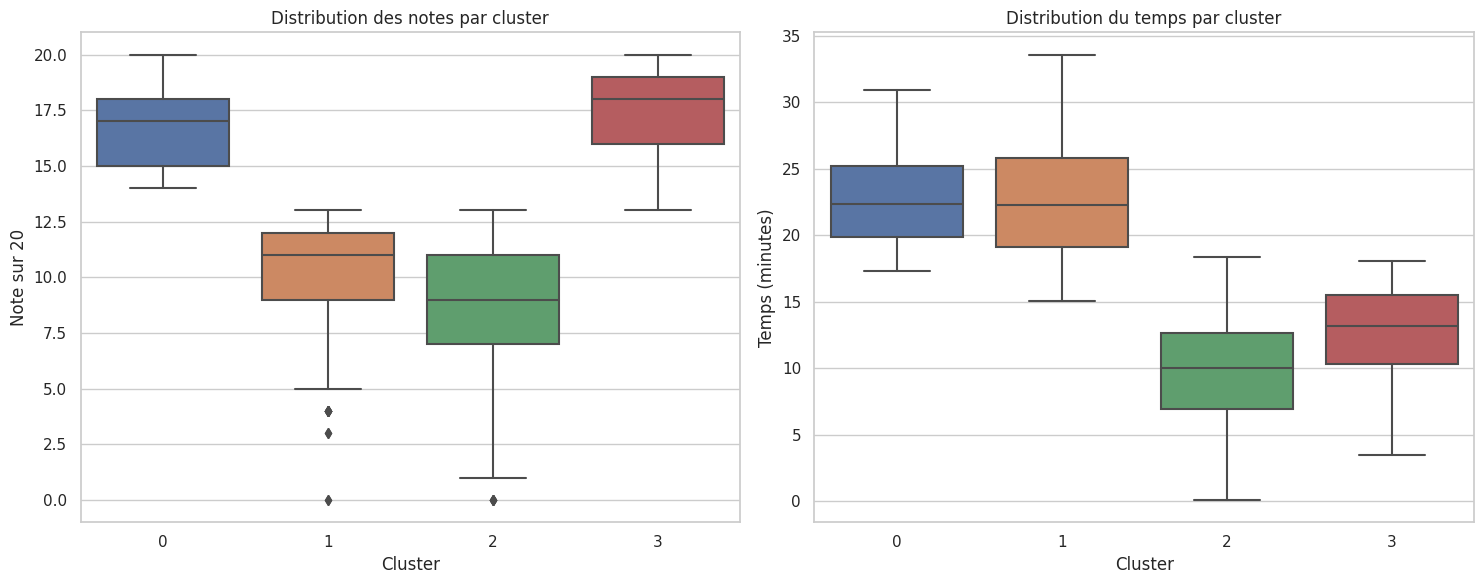

In [71]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='cluster', y='Note/20,00', data=df)
plt.title('Distribution des notes par cluster')
plt.xlabel('Cluster')
plt.ylabel('Note sur 20')

plt.subplot(1, 2, 2)
sns.boxplot(x='cluster', y='Temps utilisé (min)', data=df)
plt.title('Distribution du temps par cluster')
plt.xlabel('Cluster')
plt.ylabel('Temps (minutes)')

plt.tight_layout()
plt.show()

### Profil des clusters

In [72]:
print("Profil des clusters:")
for cluster in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster]
    print(f"\nCluster {cluster}:")
    print(f"- Nombre d'étudiants: {len(cluster_data)}")
    print(f"- Note moyenne: {cluster_data['Note/20,00'].mean():.2f}")
    print(f"- Temps moyen: {cluster_data['Temps utilisé (min)'].mean():.2f} minutes")
    print(f"- Caractéristique principale: ", end="")
    
    if cluster_data['Note/20,00'].mean() > 15:
        print("Hautes notes avec temps modéré")
    elif cluster_data['Note/20,00'].mean() < 5:
        print("Basses notes avec temps court")
    else:
        print("Notes moyennes avec temps variable")

Profil des clusters:

Cluster 0:
- Nombre d'étudiants: 643
- Note moyenne: 16.70
- Temps moyen: 22.74 minutes
- Caractéristique principale: Hautes notes avec temps modéré

Cluster 1:
- Nombre d'étudiants: 402
- Note moyenne: 10.49
- Temps moyen: 22.44 minutes
- Caractéristique principale: Notes moyennes avec temps variable

Cluster 2:
- Nombre d'étudiants: 244
- Note moyenne: 8.39
- Temps moyen: 9.60 minutes
- Caractéristique principale: Notes moyennes avec temps variable

Cluster 3:
- Nombre d'étudiants: 690
- Note moyenne: 17.36
- Temps moyen: 12.74 minutes
- Caractéristique principale: Hautes notes avec temps modéré
